# Exploratory Data Analysis (EDA) - Nepal TikTok Dataset

This notebook performs an exploratory data analysis on the Nepal TikTok dataset (`NPL_TikTok_Full_28k.csv`) to understand key patterns, trends, and insights related to video virality during the Nepal Local Election 2022. The analysis includes summary statistics, virality score computation, temporal trends, hashtag analysis, and more.

---

## 1. Import Libraries and Load Data

We start by importing the necessary libraries and loading the dataset.

```python
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pytz import timezone
from collections import Counter
from matplotlib import font_manager

# Load the dataset
df = pd.read_csv('data/NPL_TikTok_Full_28k.csv')

In [2]:
import pandas as pd

df = pd.read_csv('data/NPL_TikTok_Full_28k.csv')

/var/folders/vz/qgddhj1d00b_xrxhd73v0fdc0000gn/T/ipykernel_38258/357911919.py:3: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/NPL_TikTok_Full_28k.csv')


## 2. Dataset Overview and Summary Statistics

Let's compute basic summary statistics to understand the dataset's scale and characteristics.



In [48]:
# Compute summary statistics for the dataset
summary_stats = {
    "Total Videos": df['video_id'].nunique(),
    "Total Transcripts": df['video_description'].notna().sum(),
    "Total Comments": df['video_commentcount'].sum(),
    "Total Views": df['video_playcount'].sum(),
    "Total Shares": df['video_sharecount'].sum(),
    "Total Likes": df['video_diggcount'].sum(),
    "Total Saves/Collects": df['video_collectcount'].sum(),
    "Unique Users": df['author_id'].nunique(),
    "Verified Users": df[df['author_verified'] == True]['author_id'].nunique()
}

# Convert to DataFrame for better visualization
summary_df = pd.DataFrame.from_dict(summary_stats, orient='index', columns=['Count'])
print(summary_df)

                          Count
Total Videos              28165
Total Transcripts         28165
Total Comments           307156
Total Views           186348152
Total Shares             214808
Total Likes            14334935
Total Saves/Collects      83422
Unique Users              19993
Verified Users                9


### 3. Compute Virality Metrics
We define a virality score based on engagement metrics (likes, comments, shares, collects) and label videos into three categories: Low, Medium, and High virality.



In [49]:
# Ensure required columns exist
required_columns = ['video_diggcount', 'video_playcount', 'video_commentcount', 'video_sharecount', 'video_collectcount']
for col in required_columns:
    if col not in df.columns:
        raise KeyError(f"Missing required column: {col}")

# Calculate engagement rates
df['like_rate'] = df['video_diggcount'] / df['video_playcount']
df['comment_rate'] = df['video_commentcount'] / df['video_playcount']
df['share_rate'] = df['video_sharecount'] / df['video_playcount']
df['collect_rate'] = df['video_collectcount'] / df['video_playcount']

# Handle missing or infinite values
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

# Compute virality score using weighted engagement metrics
df['virality_score'] = (
    0.35 * np.log1p(df['video_diggcount']) +
    0.25 * np.log1p(df['like_rate']) +
    0.20 * np.log1p(df['comment_rate']) +
    0.15 * np.log1p(df['share_rate']) +
    0.05 * np.log1p(df['collect_rate'])
)

# Define thresholds for virality labels
high_thresh = df['virality_score'].quantile(0.95)  # Top 5% as High
low_thresh = df['virality_score'].quantile(0.33)   # Bottom 33% as Low

def label_virality(score):
    if score <= low_thresh:
        return 0  # Low
    elif score >= high_thresh:
        return 2  # High
    else:
        return 1  # Medium

# Apply virality labels
df['virality_label'] = df['virality_score'].apply(label_virality)

# Display the distribution of virality labels
print(df['virality_label'].value_counts())

virality_label
1    17461
0     9295
2     1409
Name: count, dtype: int64


### 4. Temporal Analysis - Convert to Nepali Timezone
We convert the video timestamps to Nepali time (NPT, UTC+5:45) and extract hour and weekday for temporal analysis.



In [50]:
# Convert timestamps to datetime and localize to Nepali timezone
df['video_time_created'] = pd.to_datetime(df['video_time_created'])
nepali_tz = timezone('Asia/Kathmandu')
df['video_time_nepali'] = df['video_time_created'].dt.tz_localize('UTC').dt.tz_convert(nepali_tz)

# Extract hour and weekday in Nepali time
df['hour_nepali'] = df['video_time_nepali'].dt.hour
df['weekday_nepali'] = df['video_time_nepali'].dt.day_name()

### 5. Visualize Virality by Time
We explore how virality varies by hour and day of the week in Nepali time.


### 5.1 Average Virality by Hour and Day

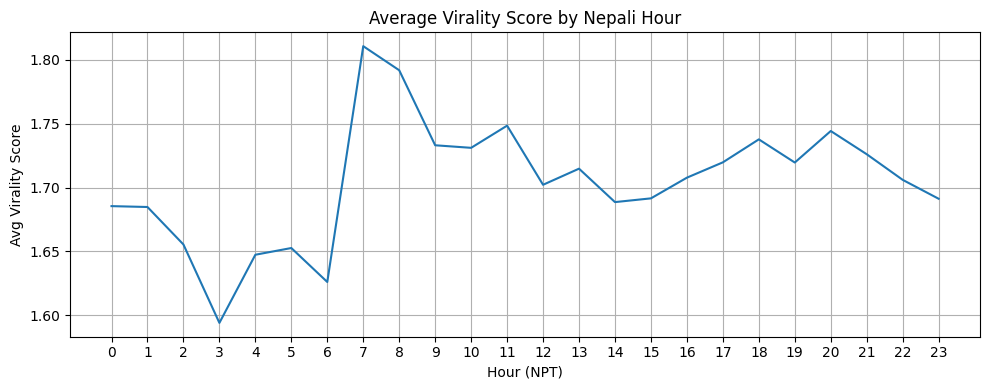

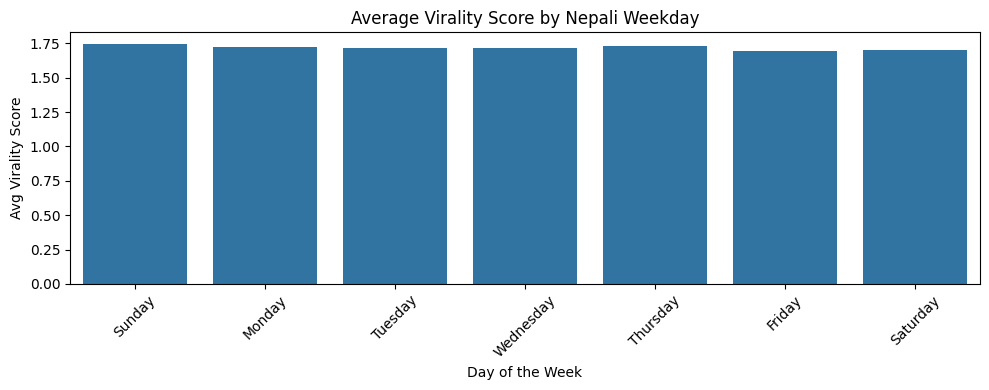

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Average Virality by hour
plt.figure(figsize=(10, 4))
sns.lineplot(data=df.groupby('hour_nepali')['virality_score'].mean().reset_index(), x='hour_nepali', y='virality_score')
plt.title('Average Virality Score by Nepali Hour')
plt.xlabel('Hour (NPT)')
plt.ylabel('Avg Virality Score')
plt.xticks(range(0, 24))
plt.grid()
plt.tight_layout()
plt.show()

# Average Virality by day
plt.figure(figsize=(10, 4))
order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sns.barplot(data=df.groupby('weekday_nepali')['virality_score'].mean().reindex(order).reset_index(), x='weekday_nepali', y='virality_score')
plt.title('Average Virality Score by Nepali Weekday')
plt.xlabel('Day of the Week')
plt.ylabel('Avg Virality Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 6. Enhanced Visualizations for Virality Trends
We create more detailed and polished visualizations for virality by hour and day, including annotations for peak values.



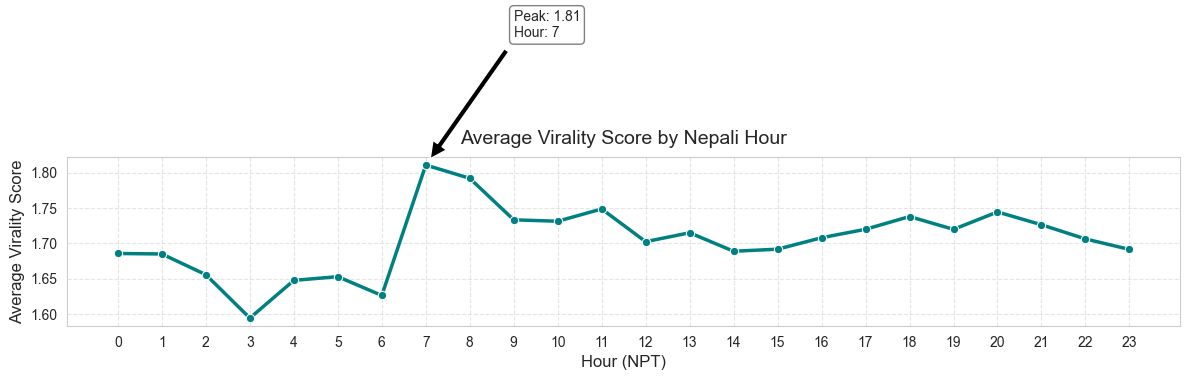

/var/folders/vz/qgddhj1d00b_xrxhd73v0fdc0000gn/T/ipykernel_38258/194690514.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=daily_virality, x='weekday_nepali', y='virality_score', palette='Blues_d')


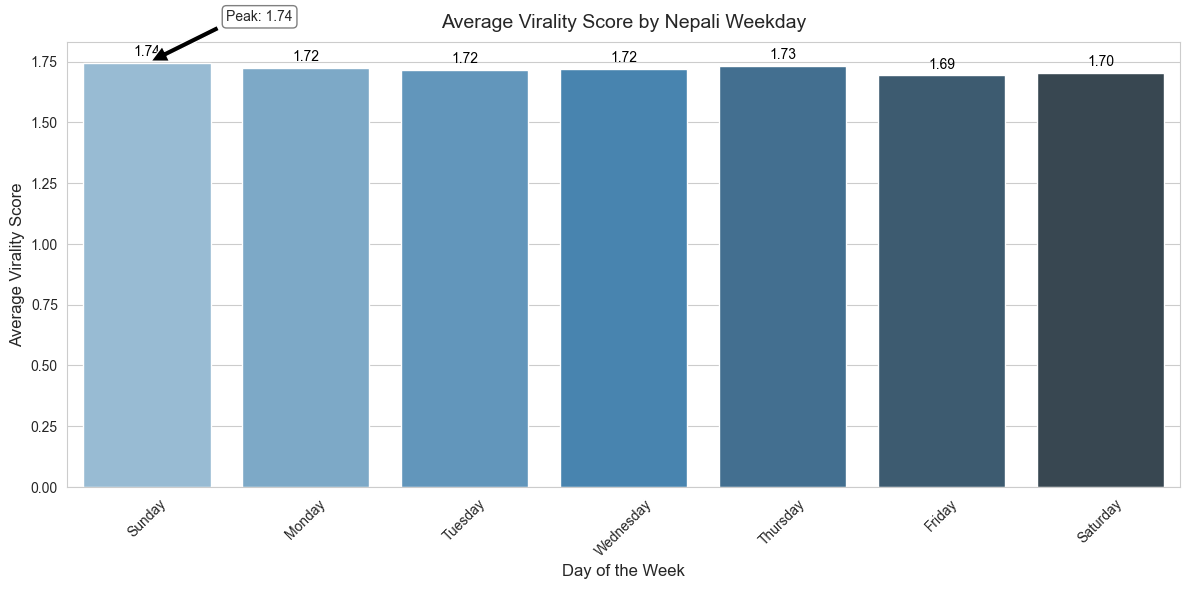

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager

# Set up Devanagari font (optional, only if Nepali text is used)
font_path = '/Users/nimathing/Documents/font/NotoSansDevanagari-Regular.ttf'  # Adjust path if needed
if font_path:
    font_manager.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Noto Sans Devanagari']  # Fallback for Latin and Devanagari

# --- Line Plot: Average Virality by Hour ---
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")  # Modern grid style

# Compute average virality by hour
hourly_virality = df.groupby('hour_nepali')['virality_score'].mean().reindex(range(0, 24), fill_value=0).reset_index()

# Plot with enhanced styling
sns.lineplot(data=hourly_virality, x='hour_nepali', y='virality_score', marker='o', color='teal', linewidth=2.5)

# Highlight peak hour
peak_hour = hourly_virality['hour_nepali'][hourly_virality['virality_score'].idxmax()]
peak_score = hourly_virality['virality_score'].max()
plt.annotate(f'Peak: {peak_score:.2f}\nHour: {int(peak_hour)}',
             xy=(peak_hour, peak_score), xytext=(peak_hour + 2, peak_score + 0.1 * peak_score),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, bbox=dict(boxstyle="round", fc="white", ec="gray"))

# Formatting
plt.title('Average Virality Score by Nepali Hour', fontsize=14, pad=10)
plt.xlabel('Hour (NPT)', fontsize=12)
plt.ylabel('Average Virality Score', fontsize=12)
plt.xticks(range(0, 24), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and show
#plt.savefig('virality_by_hour.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Bar Plot: Average Virality by Day ---
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Define day order
order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Compute average virality by day
daily_virality = df.groupby('weekday_nepali')['virality_score'].mean().reindex(order).reset_index()

# Plot with enhanced styling
barplot = sns.barplot(data=daily_virality, x='weekday_nepali', y='virality_score', palette='Blues_d')

# Add value labels on top of bars
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                     textcoords='offset points')

# Highlight peak day
peak_day = daily_virality['weekday_nepali'][daily_virality['virality_score'].idxmax()]
peak_score = daily_virality['virality_score'].max()
plt.annotate(f'Peak: {peak_score:.2f}',
             xy=(order.index(peak_day), peak_score), xytext=(order.index(peak_day) + 0.5, peak_score + 0.1 * peak_score),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, bbox=dict(boxstyle="round", fc="white", ec="gray"))

# Formatting
plt.title('Average Virality Score by Nepali Weekday', fontsize=14, pad=10)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Virality Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save and show
#plt.savefig('virality_by_day.png', dpi=300, bbox_inches='tight')
plt.show()

### 7. Video Posting Trends Over Time
We analyze the number of TikTok videos posted over time, focusing on the Nepal Local Election period (March 15, 2022, to May 15, 2022), and highlight key election phases.



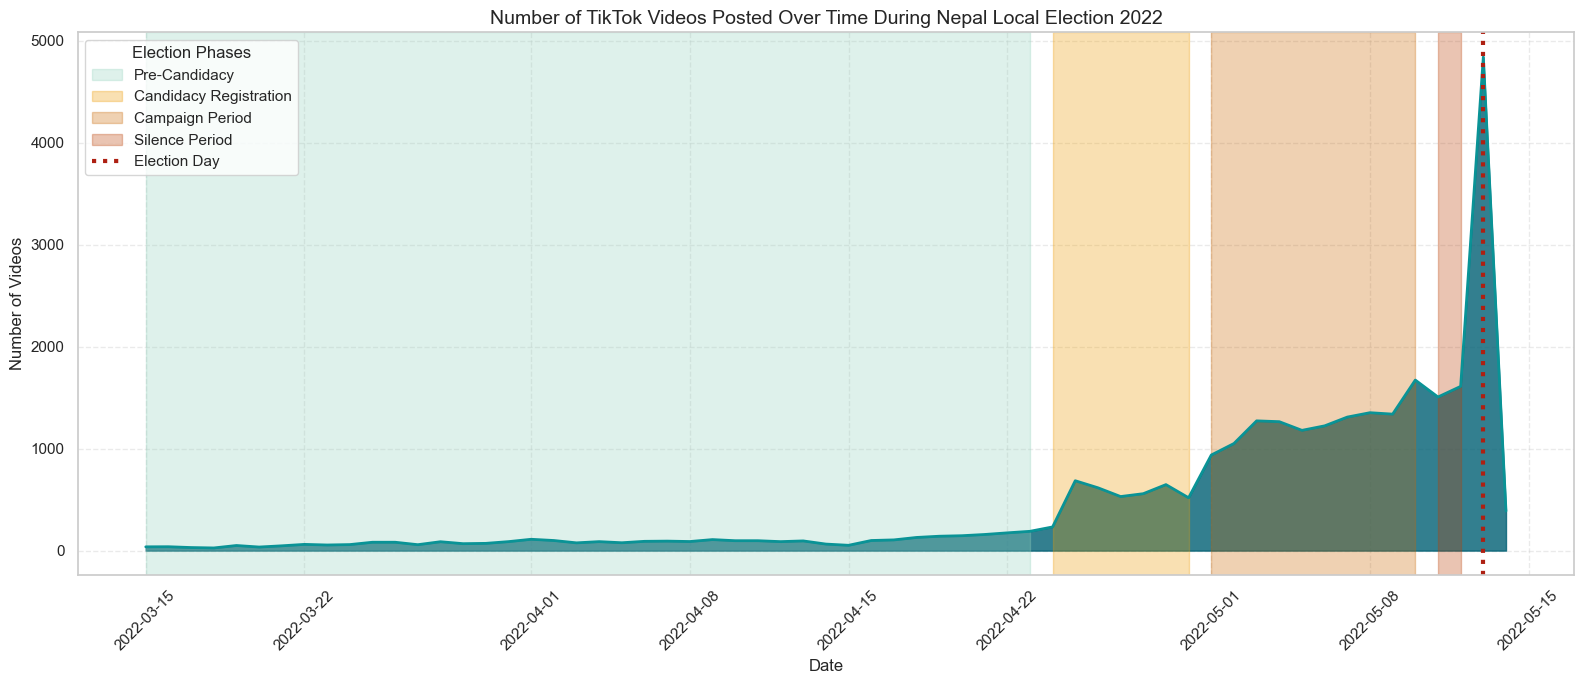

In [51]:
# Extract date from Nepali time
df['date'] = df['video_time_nepali'].dt.date

# Group by date to get video counts
video_counts_per_day = df.groupby('date').size()

# Convert index to datetime
video_counts_per_day.index = pd.to_datetime(video_counts_per_day.index)

# Filter for election period: March 15, 2022, to May 15, 2022
video_counts_per_day = video_counts_per_day.loc['2022-03-15':'2022-05-15']

# Plot with election phases
plt.figure(figsize=(16, 7))
sns.set(style="whitegrid")

# Plot filled area and line
plt.fill_between(video_counts_per_day.index, video_counts_per_day.values, color='#005f73', alpha=0.8)
plt.plot(video_counts_per_day.index, video_counts_per_day.values, color='#0a9396', linewidth=2)

# Define election phases
phases = {
    'Pre-Candidacy': ('2022-03-15', '2022-04-23', '#94d2bd'),
    'Candidacy Registration': ('2022-04-24', '2022-04-30', '#ee9b00'),
    'Campaign Period': ('2022-05-01', '2022-05-10', '#ca6702'),
    'Silence Period': ('2022-05-11', '2022-05-12', '#bb3e03'),
    'Election Day': ('2022-05-13', '2022-05-13', '#ae2012')
}

# Add phase annotations
for label, (start, end, color) in phases.items():
    if label != 'Election Day':
        plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=color, alpha=0.3, label=label)
    else:
        plt.axvline(pd.to_datetime(start), color=color, linestyle=':', linewidth=3, label=label)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', title="Election Phases")

# Formatting
plt.title("Number of TikTok Videos Posted Over Time During Nepal Local Election 2022", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Videos", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plt.savefig("Analysis/EDA/tiktok_video_counts_election_period.jpg", dpi=150, format='jpg', bbox_inches='tight')
plt.show()

### 8. Weekend vs. Weekday Virality
We compare virality scores between weekends (Saturday in Nepal) and weekdays.



In [14]:
df['is_weekend'] = df['weekday_nepali'] == 'Saturday'
df.groupby('is_weekend')['virality_score'].mean()


is_weekend
False    1.716416
True     1.704591
Name: virality_score, dtype: float64

## 9. Virality Distribution by Day
We use violin and strip plots to visualize the distribution of virality scores across days of the week.



/var/folders/vz/qgddhj1d00b_xrxhd73v0fdc0000gn/T/ipykernel_38258/4222192861.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='weekday_nepali', y='virality_score',


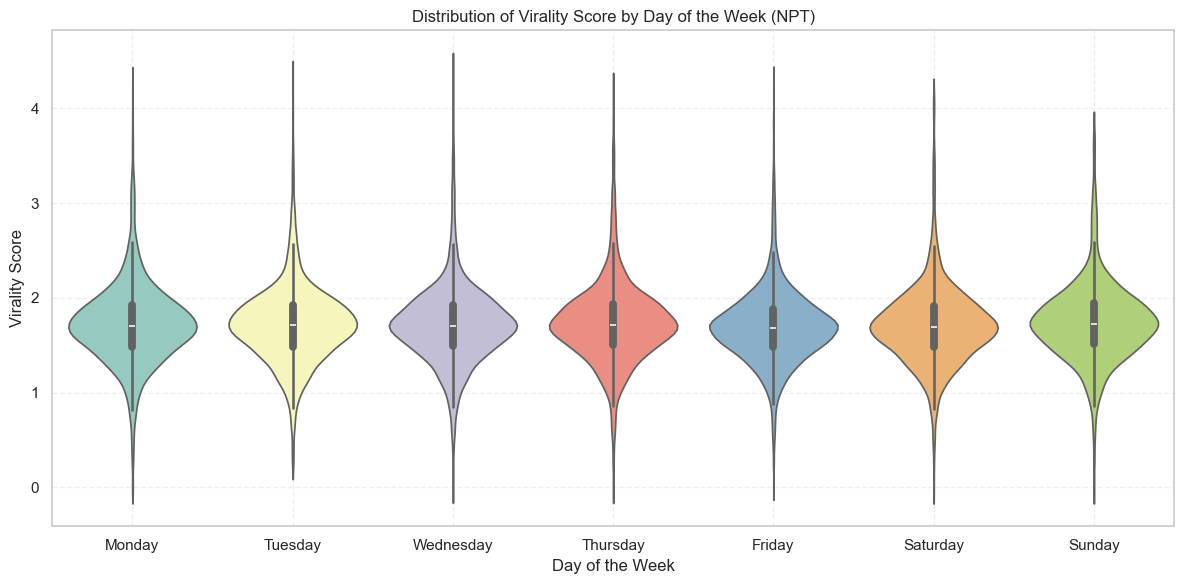

In [52]:
# Violin plot for virality distribution by day
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='weekday_nepali', y='virality_score', 
               order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
               palette='Set3')
plt.title('Distribution of Virality Score by Day of the Week (NPT)')
plt.xlabel('Day of the Week')
plt.ylabel('Virality Score')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

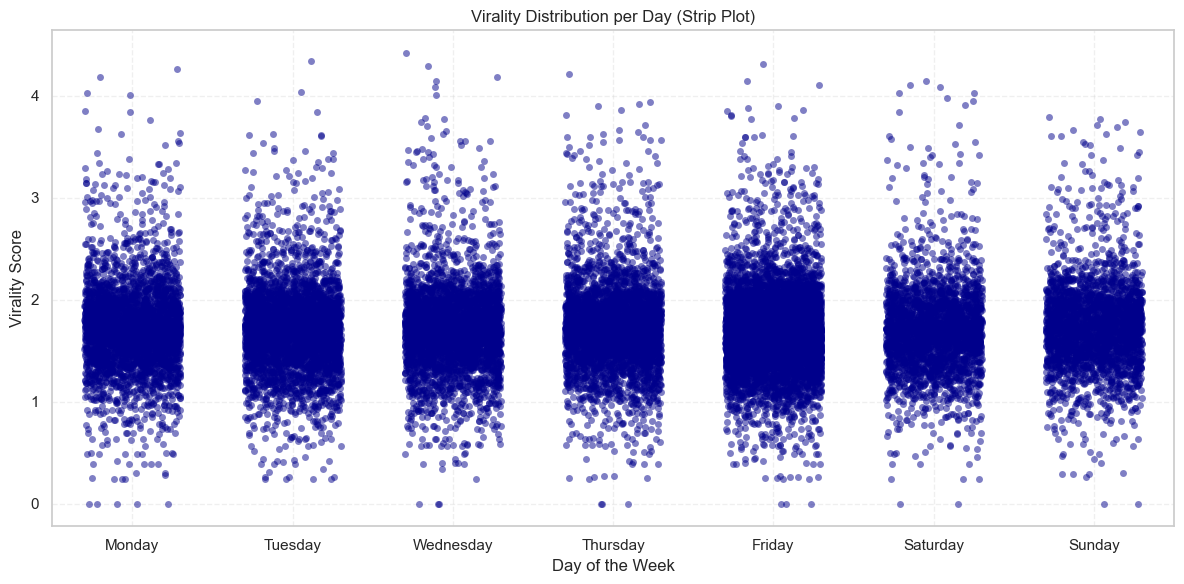

In [53]:
# Strip plot for virality distribution by day
plt.figure(figsize=(12, 6))
sns.stripplot(data=df, x='weekday_nepali', y='virality_score', 
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
              jitter=0.3, alpha=0.5, color='darkblue')
plt.title('Virality Distribution per Day (Strip Plot)')
plt.xlabel('Day of the Week')
plt.ylabel('Virality Score')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### 10. Heatmap Analysis: Virality and Posting Frequency

We create heatmaps to analyze virality and posting frequency by hour and day.



/var/folders/vz/qgddhj1d00b_xrxhd73v0fdc0000gn/T/ipykernel_38258/2440267658.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/nimathing/Documents/Projects/Github/NepalLocalElection/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


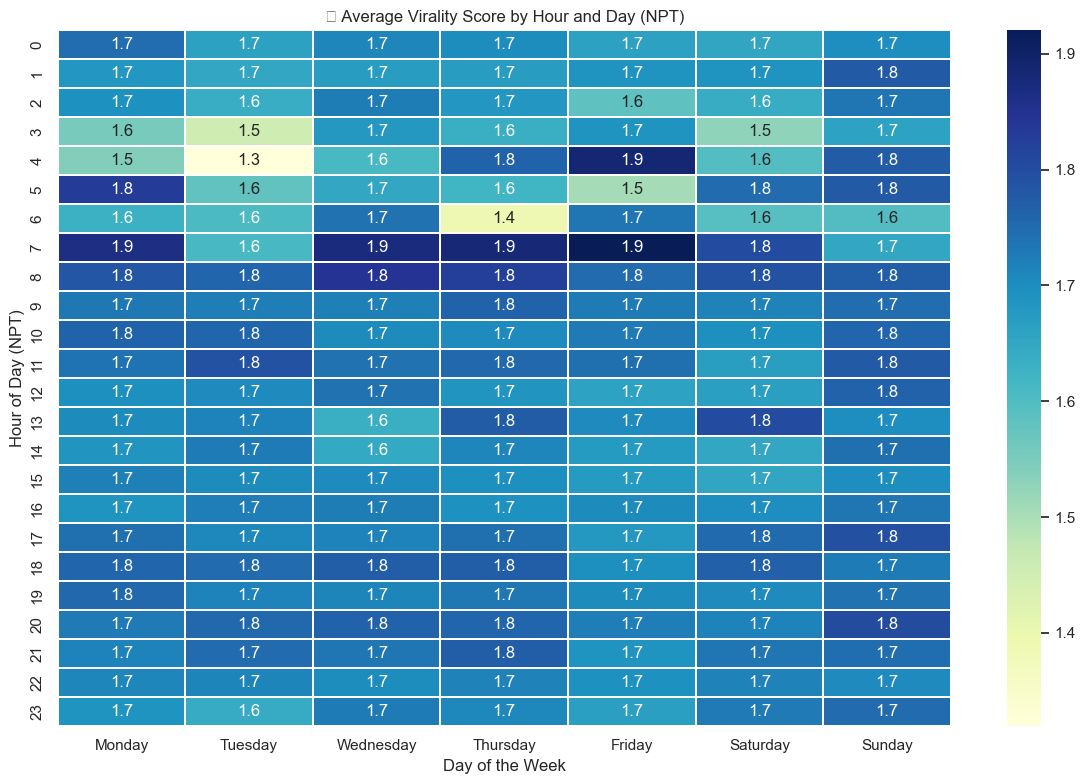

In [54]:
# Create pivot table for average virality
df['hour_npt'] = df['video_time_nepali'].dt.hour
df['day_npt'] = df['video_time_nepali'].dt.day_name()

pivot_avg = df.pivot_table(values='virality_score', index='hour_npt', columns='day_npt', aggfunc='mean').reindex(
    columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_avg, cmap='YlGnBu', linewidths=0.3, annot=True, fmt=".1f")
plt.title('📊 Average Virality Score by Hour and Day (NPT)')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of Day (NPT)')
plt.tight_layout()
plt.show()

In [20]:
import numpy as np
pivot_log = np.log1p(pivot_avg)


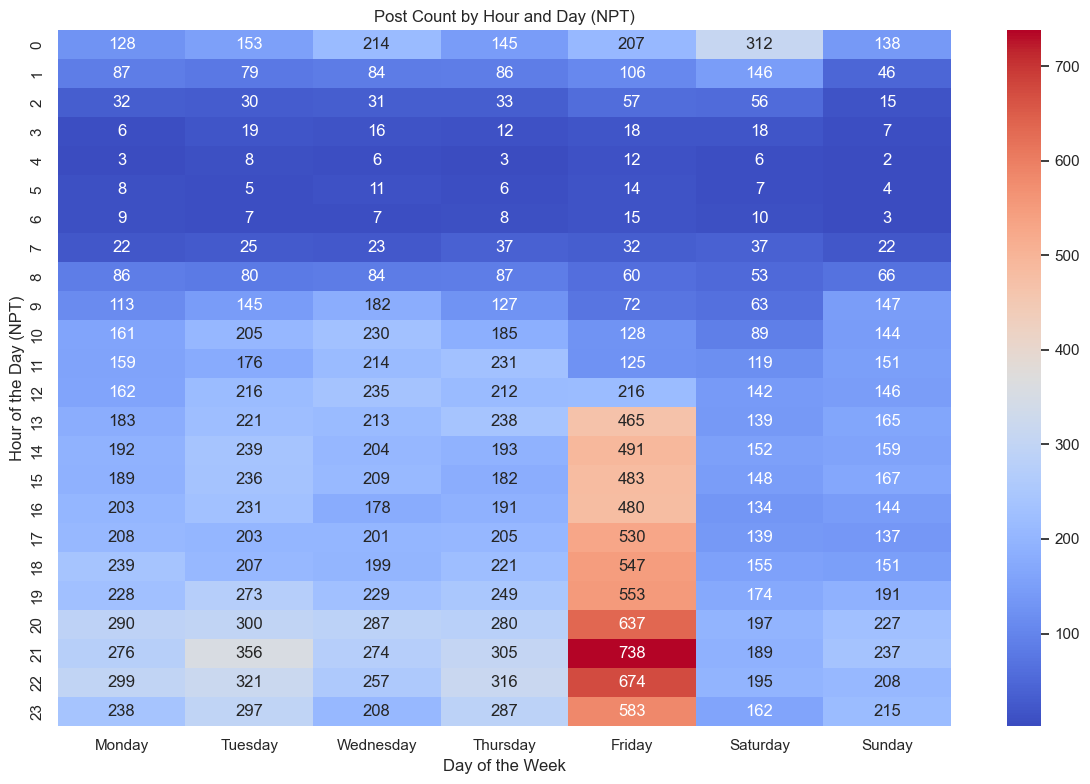

In [55]:
# Create pivot table for post counts
pivot_count = df.pivot_table(values='video_id', index='hour_npt', columns='day_npt', aggfunc='count').reindex(
    columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Fill missing values with 0
pivot_count = pivot_count.fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_count, cmap='coolwarm', annot=True, fmt=".0f")
plt.title('Post Count by Hour and Day (NPT)')
plt.xlabel("Day of the Week")
plt.ylabel("Hour of the Day (NPT)")
plt.tight_layout()

# Save plot
plt.savefig("Analysis/EDA/heatmap_post_count.jpg", dpi=150, format='jpg', bbox_inches='tight')
plt.show()

## 11. Hashtag Analysis
We analyze the usage and impact of hashtags on video virality.



### 11.1 Preprocess Hashtags



In [22]:
# Drop NA if necessary
df['video_hashtags'] = df['video_hashtags'].fillna('')

# Ensure all values are strings
df['video_hashtags'] = df['video_hashtags'].astype(str)

# Convert string to list
df['hashtags_list'] = df['video_hashtags'].apply(lambda x: [tag.strip().lower() for tag in x.split(',') if tag.strip() != ''])


### 11.2 Top Hashtags by Frequency



               Hashtag  Count
0             election   5654
1                    0   5126
2           foryoupage   3680
3                  fyp   3137
4               foryou   2899
..                 ...    ...
95        jhapalimuser     93
96               share     93
97  localelections2022     92
98         votefortree     92
99            tranding     92

[100 rows x 2 columns]


/var/folders/vz/qgddhj1d00b_xrxhd73v0fdc0000gn/T/ipykernel_38258/375395339.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[tag for tag, _ in top_20_hashtags], y=[count for _, count in top_20_hashtags], palette='Blues')
/var/folders/vz/qgddhj1d00b_xrxhd73v0fdc0000gn/T/ipykernel_38258/375395339.py:24: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vz/qgddhj1d00b_xrxhd73v0fdc0000gn/T/ipykernel_38258/375395339.py:24: UserWarning: Glyph 2330 (\N{DEVANAGARI LETTER CA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vz/qgddhj1d00b_xrxhd73v0fdc0000gn/T/ipykernel_38258/375395339.py:24: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/var/folders/vz/qgddhj1d00b_xrxhd73v0fdc0000gn/T/ipykernel_38258/375395339.py:24: Us

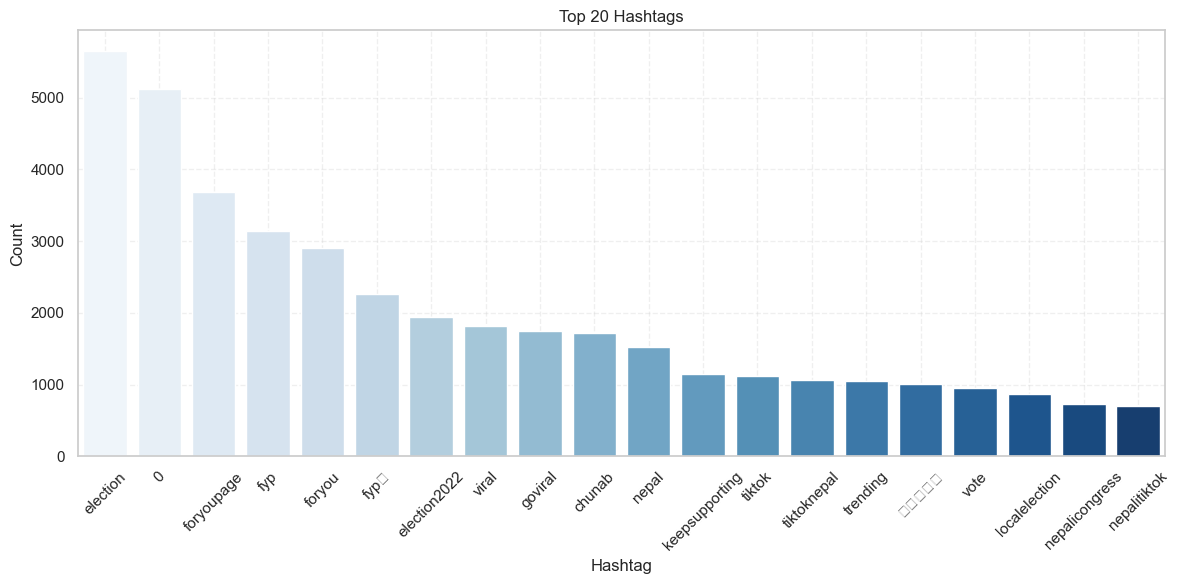

In [56]:
# Flatten hashtags and count frequencies
all_hashtags = [tag for tags in df['hashtags_list'] for tag in tags]
hashtag_counts = Counter(all_hashtags)

# Get top 100 hashtags
top_hashtags = hashtag_counts.most_common(100)

# Create DataFrame for display
table_df = pd.DataFrame(top_hashtags, columns=['Hashtag', 'Count'])
print(table_df)

# Save to CSV
table_df.to_csv('Analysis/EDA/top_100_hashtags.csv', index=False)

# Plot top 20 hashtags
top_20_hashtags = hashtag_counts.most_common(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=[tag for tag, _ in top_20_hashtags], y=[count for _, count in top_20_hashtags], palette='Blues')
plt.xticks(rotation=45)
plt.title("Top 20 Hashtags")
plt.ylabel("Count")
plt.xlabel("Hashtag")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("hashtags_plot.png", dpi=300, bbox_inches='tight')
plt.show()

### 11.3 Hashtags and Virality



                       count      mean    median
hashtags_list                                   
lalmohar                   6  3.649379  3.526017
nepalfoodvotes            12  3.527966  3.466056
comedylover                9  3.211591  2.987340
uddavgmr7                 10  3.197848  3.030750
selfcontaincreator        10  3.197848  3.030750
janatajannachahanchha     24  3.140439  3.321912
janaksaudcomedy            8  3.133922  3.048617
yograjpandey              10  3.090747  2.856661
janaksaud                 11  3.042181  3.009198
nepalicomedyvideo          8  3.022722  2.977269
thedigitalawyer           17  2.945364  2.869397
nepalilawyer              18  2.941144  2.869397
thedigitallawyer          18  2.861283  2.844358
suryapun                   7  2.762251  2.921237
rishidhamala              46  2.759215  2.770101
nepalfood                 16  2.751200  3.186225
knowyourlaw                9  2.732070  2.766379
bhunteyadav                6  2.730695  2.695596
rukummuser          

/Users/nimathing/Documents/Projects/Github/NepalLocalElection/env/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9728 (\N{BLACK SUN WITH RAYS}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/nimathing/Documents/Projects/Github/NepalLocalElection/env/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/nimathing/Documents/Projects/Github/NepalLocalElection/env/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/nimathing/Documents/Projects/Github/NepalLocalElection/env/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/nimathing/Documents/Projects/Github/NepalLocalElection/env/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: 

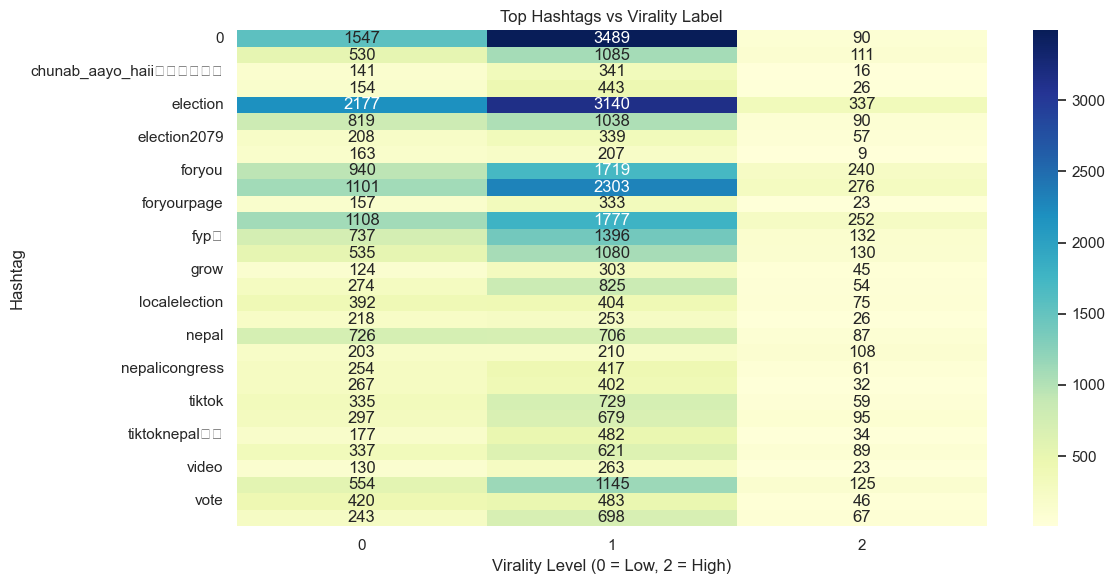

In [57]:
# Explode hashtags for analysis
df_exploded = df.explode('hashtags_list')

# Compute average virality by hashtag (for hashtags with more than 5 occurrences)
hashtag_virality = df_exploded.groupby('hashtags_list')['virality_score'].agg(['count', 'mean', 'median'])
print(hashtag_virality[hashtag_virality['count'] > 5].sort_values('mean', ascending=False).head(20))

# Heatmap: Top hashtags vs. virality label
hashtag_virality = df_exploded.groupby(['hashtags_list', 'virality_label']).size().unstack(fill_value=0)
top_hashtag_names = [tag for tag, _ in hashtag_counts.most_common(30)]
hashtag_virality = hashtag_virality.loc[hashtag_virality.index.isin(top_hashtag_names)]

plt.figure(figsize=(12, 6))
sns.heatmap(hashtag_virality, cmap='YlGnBu', annot=True, fmt='d')
plt.title("Top Hashtags vs Virality Label")
plt.ylabel("Hashtag")
plt.xlabel("Virality Level (0 = Low, 2 = High)")
plt.tight_layout()
plt.show()

### 12. Verified Status and Virality
We explore the relationship between the author's verified status and video virality.



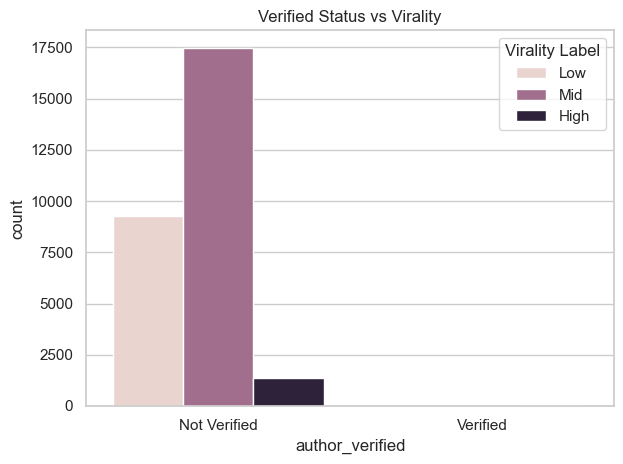

In [58]:
# Plot verified status vs. virality label
sns.countplot(data=df, x='author_verified', hue='virality_label')
plt.xticks([0, 1], ['Not Verified', 'Verified'])
plt.legend(title='Virality Label', labels=['Low', 'Mid', 'High'])
plt.title("Verified Status vs Virality")
plt.tight_layout()
plt.show()

### 13. Diversification Labels and Virality
We analyze how diversification labels correlate with virality.



virality_label                                             0         1  \
video_diversification_labels                                             
['Art', 'Talents']                                  0.000000  0.000000   
['Celebrity Clips & Variety Show', 'Entertainme...  0.083333  0.166667   
['Food Display', 'Food & Drink', 'Lifestyle']       0.000000  0.000000   
['Lip-sync']                                        0.000000  0.142857   
['Scripted Drama']                                  0.000000  0.000000   
['Software & APPs', 'Technology', 'Culture & Ed...  0.000000  0.000000   
['Street Interviews & Social Experiments', 'Soc...  0.000000  0.000000   

virality_label                                             2  
video_diversification_labels                                  
['Art', 'Talents']                                  1.000000  
['Celebrity Clips & Variety Show', 'Entertainme...  0.750000  
['Food Display', 'Food & Drink', 'Lifestyle']       1.000000  
['Lip-sync']      

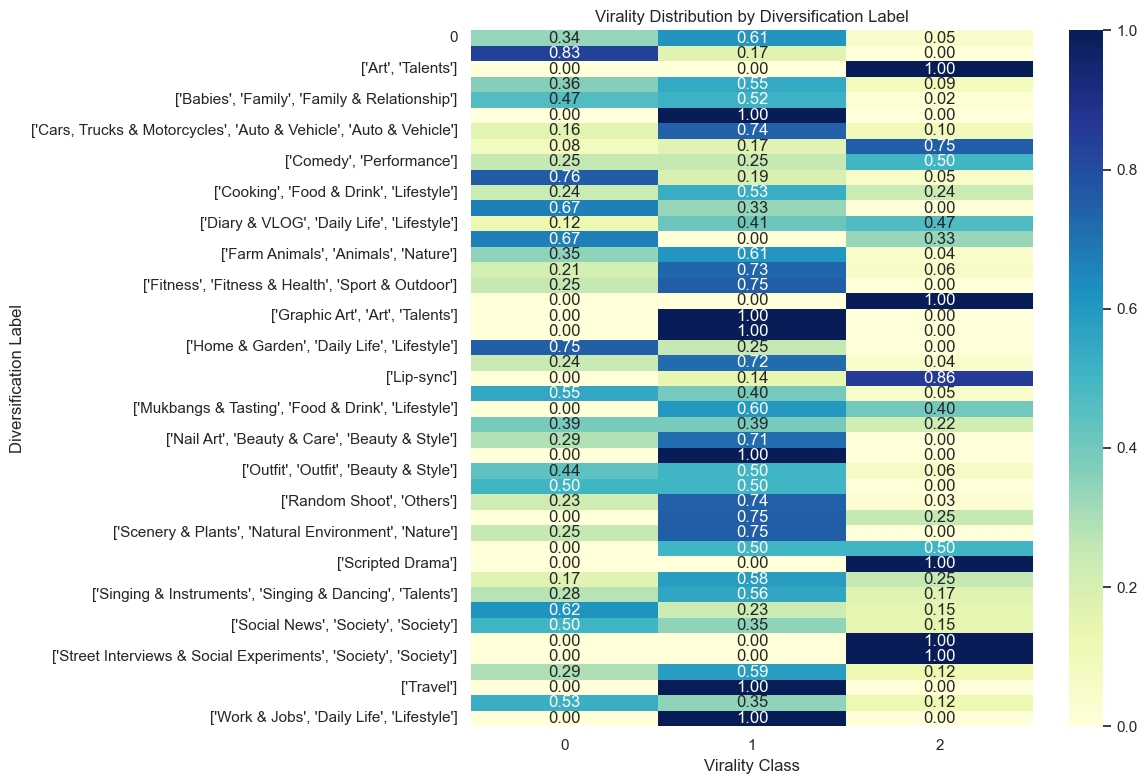

In [59]:
# Compute virality proportions by diversification label
div_label_stats = df.groupby("video_diversification_labels")["virality_label"].value_counts(normalize=True).unstack().fillna(0)

# Display themes where high virality (class 2) is dominant
top_viral_themes = div_label_stats[div_label_stats[2] > 0.65]
print(top_viral_themes)

# Plot heatmap of virality distribution
plt.figure(figsize=(12, 8))
sns.heatmap(div_label_stats[[0, 1, 2]], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Virality Distribution by Diversification Label")
plt.ylabel("Diversification Label")
plt.xlabel("Virality Class")
plt.tight_layout()
plt.show()